## Choosing EU ETS vs Carbon TAX
EU ETS start only at 2005 and Carbon Tax depends on countries that have already implemented it but could go as early as 1990.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display

carbon_pricing_data = pd.read_excel('./ggdp_data/world_bank/world_bank_carbon_pricing.xlsx', header=1,
                                    sheet_name='Compliance_Price', na_values='-')
carbon_pricing_data = carbon_pricing_data.set_index('Name of the initiative').T
carbon_pricing_data.rename(columns=lambda x: str.lower(x.replace(' ', '_')), inplace=True)
#dropping all metadata rows
carbon_pricing_data = carbon_pricing_data.iloc[7:]
carbon_pricing_data = carbon_pricing_data.apply(pd.to_numeric)
carbon_pricing_data.index = [str(x) for x in carbon_pricing_data.index]

eu_ets = carbon_pricing_data['eu_ets']
finland_carbon_tax = carbon_pricing_data['finland_carbon_tax']
#Finland has two types of carbon tax: Transport fuels, heating fuels which are the same across the whole series
finland_carbon_tax = finland_carbon_tax.iloc[:, 0]

In [2]:
#checking to see if EU ETS can proxy for carbon tax or the other way round. Does any one of them hold and additional information?
ets_joined_carbon_tax = pd.DataFrame(eu_ets).join(finland_carbon_tax)
ets_joined_carbon_tax = ets_joined_carbon_tax.dropna()
ets_joined_carbon_tax.head()

model = sm.OLS.from_formula('eu_ets ~ finland_carbon_tax', data=ets_joined_carbon_tax)
results = model.fit()
results.summary()


,eu_ets,finland_carbon_tax
2005,19.04,13.92
2006,32.24,14.91
2007,1.25,13.55
2008,34.48,12.65
2009,15.55,15.40


C:\Users\yarde\anaconda3\envs\ggdp-research\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 eu_ets   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     3.365
Date:                Tue, 30 Jul 2024   Prob (F-statistic):             0.0842
Time:                        17:29:46   Log-Likelihood:                -86.898
No. Observations:                  19   AIC:                             177.8
Df Residuals:                      17   BIC:                             179.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.4432     11.154      0.667      0.514     -16.090      30.976
finland_carbon_tax     0.3522      0.192      1.834      0.084      -0.053       0.757
==============================================================================
Omnibus:                        6.489   Durbin-Watson:                   0.533
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                4.314
Skew:                           1.139   Prob(JB):                        0.116
Kurtosis:                       3.508   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Analysing Results
I was looking to see if ets and carbon tax are very correlated, if they are then I could probably assume that one of them proxies for the other. We can see that linear relationship between the variables is insignificant. Meaning that they don't proxy linearly for each other. Thus I should probably use one of them or a combination of both when calculating the GGDP results.

## Calculating GGDP
The base formula which I'm going to use is this: $ GGDP = GDP - KtCO_{2} \cdot P_{tCO_2} - Twaste \cdot 74 kWh \cdot P_{1 kWh elec} - GNI \cdot \% NRD/100 $

First term - air pollution
Second Term - waste pollution translated into electricity cost
Third Term - Natural resource depletion

The 74 figure is based on different papers: check this

Managed to find all the data for this: arises the question of what data to include and how.

The problems with this base formula are:
1. doesn't account for defensive costs - the cost of restoring and protecting the environment. Need to find figures for this.
2. the figure 74 isn't really based on anything concrete (the citing is quite unclear)
3. no accounting for green innovation - not even sure if I want to add this, but perhaps I should

The main problem with actually deriving GGDP is data availability and lack of accounting standard that can be implemented using available data.

### Making some adjustments to get more accurate data

The term $Natural Resource Depletion Cost = GNI \cdot \% NRD/100 $ is in effect caulculated using current dollar terms of GNI and not GNI[PPP] which changes the calculation method and the units. So insted we will now just directly calculate $NRD Cost = C_{forest} + C_{mineral} + C_{energy}$ (as the World Bank calculates it in the WDI database).
In addition, we will not use the figure 74kWh because it's not really clear what it's based on, but I found a paper that explains that it's possible to create a closed self-sustainable system which generates 800kWh per 2 tons/hour waste -> 400 kWh from 1 ton/hour of waste.

Particulate Emission Damage - another available series is particulate emission damage, which in my opinion accounts for some of the health adjustments to GDP as a result of using non-green drivers. It is not necessarily required so I will first calculate GGDP without it and then add it to see how it affects it.

Defensive Costs - Defensive costs for finland started being recorded only from around 2014 which doesn't allow for much data. The question that arises is whether it should be accounted for at all since the data is in fact incomplete (Finland didn't really only start investing in defensive costs only since 2014). It would be possible to simulate some of the data for this, but I don't think it's a good idea because we have so little samples for this data.

Essentially the formula we are going to use is: \
$ GGDP_{t} = GDP_{t} - C_{e,t}-C_{r,t}-C_{s,t} $ \
$ C_{e,t} = CO_{2} \cdot P_{co2} $ \
$ C_{r,t} = NRD Cost_{t} = C_{forest,t} + C_{mineral,t} + C_{energy,t}$ \
$ C_{s,t} = Particulate Damage Cost $


In [3]:
wdi_data = pd.read_excel('./ggdp_data/world_bank/P_Data_Extract_From_World_Development_Indicators_v3.xlsx', header=0,
                         sheet_name='Data', na_values='..')
wdi_data = wdi_data.set_index('Country Name').T
wdi_data = wdi_data.drop(['Series Code'])
wdi_data = wdi_data.rename({"Series Name": "variable_name"})
wdi_data = wdi_data.rename(index=lambda x: x[:y] if (y := x.find(' ')) != -1 else x)
wdi_data = wdi_data.dropna(axis='columns', how='all')


def replace_values_from_dict(curr_value, value_dict: dict):
    try:
        return value_dict[curr_value]
    except KeyError:
        return curr_value


#I refer to international dollar as ppp
wdi_variables_to_replace = {'CO2 emissions (kt)': 'co2_kt',
                            'GDP (current US$)': 'gdp_dollar',
                            'Adjusted savings: energy depletion (current US$)': 'as_energy_depletion',
                            'Adjusted savings: mineral depletion (current US$)': 'as_mineral_depletion',
                            'Adjusted savings: net forest depletion (current US$)': 'as_forest_depletion',
                            'PPP conversion factor, GDP (LCU per international $)': 'lcu_to_ppp',
                            'Adjusted savings: particulate emission damage (current US$)': 'as_particulate_emission_damage',
                            'GDP, PPP (current international $)': 'gdp_ppp',
                            'GDP (current LCU)': 'gdp_lcu',
                            'GDP (constant 2015 US$)' : 'gdp_constant_2015_dollar'
                            }


#renaming variables
wdi_data.loc['variable_name'] = (wdi_data.loc['variable_name']).apply(replace_values_from_dict,
                                                                      args=(wdi_variables_to_replace,))


def change_col_names_to_country(df: pd.DataFrame):
    column_name_list = []
    curr_col_name: str
    for curr_col_name, curr_series in df.items():
        #'country-name'_'variable-name'
        new_column_name = f'{curr_col_name.lower()}_{curr_series["variable_name"]}'
        column_name_list.append(new_column_name)
    df.columns = column_name_list



#combine all finland data into one dataframe to avoid problems with dates
finland_data = wdi_data['Finland']
#mmore emissions data from fin stat website



change_col_names_to_country(finland_data)
finland_data = finland_data.drop(index=['Country', 'variable_name'])
finland_data = finland_data.join(finland_carbon_tax, how='left')

#removing old wdi emissions column and adding the data from fin stat because it has newer data.
fin_emissions_data = pd.read_csv('ggdp_data/finalnd_statistics_db/finland_emissions_kt.csv')
fin_emissions_data.index = fin_emissions_data['Year'].apply(lambda x: str(x))
finland_data = finland_data.drop(columns=['finland_co2_kt'])
finland_data = finland_data.join(fin_emissions_data['co2 kt without LULUCF'])
finland_data = finland_data.rename(columns={'co2 kt without LULUCF':'finland_co2_kt'})

finland_data = finland_data.apply(pd.to_numeric)

finland_data.to_pickle('ggdp_processed_data/wdi_data_processed.pkl')

#calculating natural resource depletion cost in dollars
finland_data['finland_as_nrd_cost'] = (finland_data['finland_as_energy_depletion'] +
                                       finland_data['finland_as_mineral_depletion'] +
                                       finland_data['finland_as_forest_depletion'])

#use this to convert from EUR to current dollar
finland_data['finland_dollar_to_lcu'] = finland_data['finland_gdp_dollar'] / finland_data['finland_gdp_lcu']
finland_data['finland_ppp_to_dollar'] = 1 / (finland_data['finland_dollar_to_lcu'] * finland_data['finland_lcu_to_ppp'])

#nominal gdp = deflator * real gdp
finland_data['gdp_2015_dollar_deflator'] = finland_data['finland_gdp_dollar']/finland_data['finland_gdp_constant_2015_dollar']

There's a problem with calculating waste because not enough waste data is available in order to constrcut the waste cost term. So there's a need to do imputation.
I thought it would make sense to do the imputation by regressing waste on gdp, since as the country has more economic output the more waste it's going to have.

I tried regressing Net Waste on GGDP[PPP] but I couldn't reject the null so decided not to use that model. But when I did a log transform it worked better, now I can reject both hypotheses and we get the model: $\log(Net Waste) = -14.4018 + 1.2512 * \log(GDP[PPP]) $. We get a very high R-squared as well.
We can use this result to fill in the missing values all the way to 1990.

In [4]:
#Waste calculation
# Waste generation data preparation and projections
waste_gen_data = pd.read_csv('./ggdp_data/eurostat_generation_of_waste_by_category.csv')
waste_treatment_data = pd.read_csv('./ggdp_data/eurostat_waste_treatment_by_waste_category.csv')

#getting Finland's total waste generation
finland_gen_total = waste_gen_data[(waste_gen_data['geo'] == 'FI') & (waste_gen_data['waste'] == 'TOTAL')]
finland_gen_total.index = finland_gen_total['TIME_PERIOD']
#getting Finland's total energy recovery from waste, since we are pricing waste through energy prices.
finland_energy_recovery = waste_treatment_data[
    (waste_treatment_data['geo'] == 'FI') & (waste_treatment_data['wst_oper'] == 'RCV_E')]
finland_energy_recovery.index = finland_energy_recovery['TIME_PERIOD']

net_waste_data = pd.DataFrame()
#calculating net waste: net_waste = generated_waste - energy_recovered_from_waste
net_waste_data['finland_net_waste'] = finland_gen_total['OBS_VALUE'] - finland_energy_recovery['OBS_VALUE']

net_waste_data.index = [str(x) for x in net_waste_data.index]

#is GDP correlated with waste

gdp_waste_data = net_waste_data.join(finland_data['finland_gdp_ppp'])

gdp_waste_data['finland_net_waste_log'] = np.log(gdp_waste_data['finland_net_waste'])
gdp_waste_data['finland_gdp_ppp_log'] = np.log(gdp_waste_data['finland_gdp_ppp'])

model = sm.OLS.from_formula('finland_net_waste_log ~ finland_gdp_ppp_log', data=gdp_waste_data)
results = model.fit()
results.summary()

C:\Users\yarde\anaconda3\envs\ggdp-research\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     finland_net_waste_log   R-squared:                       0.811
Model:                               OLS   Adj. R-squared:                  0.784
Method:                    Least Squares   F-statistic:                     30.07
Date:                   Tue, 30 Jul 2024   Prob (F-statistic):           0.000923
Time:                           17:29:47   Log-Likelihood:                 7.3751
No. Observations:                      9   AIC:                            -10.75
Df Residuals:                          7   BIC:                            -10.36
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -14.4018      5.962     -2.416      0.046     -28.499      -0.304
finland_gdp_ppp_log     1.2512      0.228      5.483      0.001       0.712       1.791
==============================================================================
Omnibus:                        1.157   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.561   Jarque-Bera (JB):                0.678
Skew:                           0.207   Prob(JB):                        0.713
Kurtosis:                       1.721   Cond. No.                     3.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [5]:
#adding the model from the regression to the data
finland_data['finland_gdp_ppp_log'] = np.log(finland_data['finland_gdp_ppp'])
finland_data['net_waste_log'] = results.params['Intercept'] + finland_data['finland_gdp_ppp_log'] * results.params[
    'finland_gdp_ppp_log']
finland_data['net_waste'] = np.exp(finland_data['net_waste_log'])


### Electricity Price
We use electricity price to be able to price solid waste. The problem is electricity price is tiered so the calculation has to be done accordingly. What I plan on doing is taking the fractional part of the total waste converted to electricity respective to house-hold use and industrial use in Finland and then look at each one of them as if it were a single consumer. This is an obvious over-simplification but otherwise there is no way of calculating it because of a lack of data.

In [6]:
from electrcity_processing_functions import tax_tier_map, process_electricity_df, process_electricity_consumption_df

elec_hh_pre_2007 = pd.read_csv('./ggdp_data/eurostat_electricity/eurostat_electricity_price_hh_pre_2007.csv', header=0)
elec_hh_pre_2007_processed = process_electricity_df(country_code='FI', elec_df=elec_hh_pre_2007)
elec_hh_post_2007 = pd.read_csv('./ggdp_data/eurostat_electricity/eurostat_electricity_price_hh_post_2007.csv',
                                header=0)

#there's overlap with the two dataframe: both have 2007 data
elec_hh_pre_2007_index_to_drop = elec_hh_pre_2007_processed[elec_hh_pre_2007_processed['year'] == '2007'].index
elec_hh_pre_2007_processed = elec_hh_pre_2007_processed.drop(index=elec_hh_pre_2007_index_to_drop)

elec_hh_post_2007_processed = process_electricity_df(country_code='FI', elec_df=elec_hh_post_2007)
elec_hh = pd.concat([elec_hh_post_2007_processed, elec_hh_pre_2007_processed])
elec_hh = elec_hh.replace({'tax_tier': tax_tier_map})
elec_hh['tax_tier'] = pd.to_numeric(elec_hh['tax_tier'])
elec_hh['year'] = pd.to_numeric(elec_hh['year'])

elec_nh_pre_2007 = pd.read_csv('./ggdp_data/eurostat_electricity/eurostat_electricity_price_nh_pre_2007.csv')
elec_nh_pre_2007_processed = process_electricity_df(country_code='FI', elec_df=elec_nh_pre_2007)
elec_nh_post_2007 = pd.read_csv('./ggdp_data/eurostat_electricity/eurostat_electricity_price_nh_post_2007.csv')
elec_nh_post_2007_processed = process_electricity_df(country_code='FI', elec_df=elec_nh_post_2007)
elec_nh = pd.concat([elec_nh_post_2007_processed, elec_nh_pre_2007_processed])
elec_nh = elec_nh.replace({'tax_tier': tax_tier_map})
elec_nh['tax_tier'] = pd.to_numeric(elec_nh['tax_tier'])
elec_nh['year'] = pd.to_numeric(elec_nh['year'])

elec_consumption = pd.read_csv('./ggdp_data/eurostat_electricity/eurostat_electricity_consumption.csv', header=0)
elec_consump_processed = process_electricity_consumption_df(country_code='FI', df=elec_consumption)


C:\Users\yarde\PycharmProjects\ggdp_research\electrcity_processing_functions.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'year'] = filtered_df['TIME_PERIOD'].apply(lambda x: x[:x.find('-')])
C:\Users\yarde\PycharmProjects\ggdp_research\electrcity_processing_functions.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_df['price'] = filtered_df.loc[:, 'price'].fillna(method='ffill')
C:\Users\yarde\PycharmProjects\ggdp_research\electrcity_processing_functions.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

When looking at electricity prices I only decided to look at electricity prices for household and non-household consumptio because the cost for household vs non-hosehold electricty prices are different. This presents a bit of a challange in pricing electricity becasue it raises the question of which rate to use. I decided to take the relative part of household and non-household from the WTE output. For example if HH is 2/3 of the total consumption and NH is 1/3 so we will price 2/3 of WTE using HH pricess and a 1/3 of WTE using NH prices.

In [7]:
from numpy import nan


#some electricity prices for post 2007 data are missing for finland data so I took official data from Statistics Finland’s free-of-charge statistical databases
# I plan on merging the data together to get as much data as possible
def process_fin_stat_df(df: pd.DataFrame) -> pd.DataFrame:
    df['year'] = df['Month'].apply(lambda x: x[:x.find('M')])
    df = df.replace({'..': nan})
    df = df.dropna(axis='columns', how='all')
    df = df.drop(columns=['Month'])
    df = df.apply(pd.to_numeric)
    average_yearly_price_df = df.groupby(['year'], as_index=False).mean()
    average_yearly_with_tax_tier_rows = []

    for index, row in average_yearly_price_df.iterrows():
        tax_tiers = list(row.index.values)
        tax_tiers.remove('year')
        for tier in tax_tiers:
            average_yearly_with_tax_tier_rows.append(
                {'year': row['year'],
                 'tax_tier': tier,
                 'price': row[tier] / 100,
                 'currency': 'EUR'}
            )
    return pd.DataFrame(average_yearly_with_tax_tier_rows)

    #for each year we have a price for each consumption range


fin_stat_elec_price_hh = pd.read_csv('ggdp_data/finalnd_statistics_db/finalnd_statistics_hh_elec_prices.csv', header=0)
fin_stat_elec_price_hh = process_fin_stat_df(fin_stat_elec_price_hh)

fin_stat_elec_price_nh = pd.read_csv('ggdp_data/finalnd_statistics_db/finalnd_statistics_nh_elec_prices.csv', header=0)
fin_stat_elec_price_nh = process_fin_stat_df(fin_stat_elec_price_nh)

#combining both datasets
#for hh we start at 2009 for official dataset, so anything prior to that will be taken from processed dataset


hh_elec_filtered_to_combine_eurostat = elec_hh[(elec_hh['currency'] == 'EUR') & (elec_hh['year'] < 2009)]
hh_elec_combined = pd.concat([hh_elec_filtered_to_combine_eurostat, fin_stat_elec_price_hh])
hh_elec_combined = hh_elec_combined.sort_values(by=['year', 'tax_tier'])
hh_elec_combined['tax_tier'] = pd.to_numeric(hh_elec_combined['tax_tier'])

#


nh_elec_filtered_to_combine_eurostat = elec_nh[(elec_nh['currency'] == 'EUR') & (elec_nh['year'] < 2008)]

index_of_missing_val = fin_stat_elec_price_nh[
    (fin_stat_elec_price_nh['year'] == 2008) & (fin_stat_elec_price_nh['tax_tier'] == '20000')].index
price_for_filling = \
    elec_nh[(elec_nh['year'] == 2008) & (elec_nh['currency'] == 'EUR') & (elec_nh['tax_tier'] == 20000)].squeeze(
        axis=0)[
        'price']
fin_stat_elec_price_nh.loc[index_of_missing_val, 'price'] = price_for_filling

nh_elec_combined = pd.concat([nh_elec_filtered_to_combine_eurostat, fin_stat_elec_price_nh])
nh_elec_combined['tax_tier'] = pd.to_numeric(nh_elec_combined['tax_tier'])

## Units for GGDP
- Carbon pricing - carbon tax is dollar/kilo-ton of CO2 emission
- waste cost - is in dollars
- NRD - in percentage of GDP
- GDP - can be in ppp or dollars. I'll choose to work with dollars for uniformity of the data
I want to work with real GGDP, GGDP[PPP] in order to get real growth rates and not just nominal ones. This is especially important when comparing different countries or scenrios since if a specific policy will increase GGDP growth but might actually cause an infaltion increase which is greater, thus actually shrinking real GGDP.

In [8]:
from numpy import nan

from consumption_functions import calculate_energy_cost

finland_ggdp = pd.DataFrame()
#calculating GGDP with current data
#Calculating GGDP using base formula

#emission cost
#carbon tax is us$/ton of CO2
#perhaps need to convert this to ppp
finland_ggdp['co2_emission_cost_dollar'] = finland_data['finland_co2_kt'] * 1000 * finland_data['finland_carbon_tax']

#waste cost
#need to add electricity price
wte_conversion_constant = 400  # kWh/ton of waste
total_wte: pd.Series = finland_data['net_waste'] * wte_conversion_constant
years_index = list(total_wte.index)
years_series = pd.Series({year: int(year) for year in years_index}, index=years_index)
years_series.name = 'year'
wte_df = pd.concat([total_wte, years_series], axis=1)

#This is in EURO
#Need to convert EUR (lcu) to current dollars
finland_ggdp['waste_cost_eur'] = wte_df.apply(lambda x: calculate_energy_cost(wte=x['net_waste'],
                                                                              year=x['year'], currency='EUR',
                                                                              elec_consumption=elec_consump_processed,
                                                                              hh_elec=hh_elec_combined,
                                                                              nh_elec=nh_elec_combined)
                                              , axis=1)

finland_ggdp = finland_ggdp.join(
    finland_data[['finland_dollar_to_lcu', 'finland_ppp_to_dollar', 'finland_as_particulate_emission_damage', 'finland_gdp_ppp']])
finland_ggdp['waste_cost_dollar'] = finland_ggdp['waste_cost_eur'] * finland_ggdp['finland_dollar_to_lcu']

#natural resource depltion cost in current dollar
finland_ggdp['natural_nrd_cost_dollar'] = finland_data['finland_as_nrd_cost']

#in current dollar
finland_ggdp['ggdp_current_dollar'] = finland_data['finland_gdp_dollar'] - finland_ggdp['co2_emission_cost_dollar'] - \
                              finland_ggdp[
                                  'waste_cost_dollar'] - finland_ggdp['natural_nrd_cost_dollar']
#in 2015 constant dollar. real terms
finland_ggdp['ggdp_constant_dollar'] = finland_ggdp['ggdp_current_dollar']/finland_data['gdp_2015_dollar_deflator']

#in ppp dollar
finland_ggdp['ggdp_dollar_ppp'] = finland_ggdp['ggdp_current_dollar'] * finland_ggdp['finland_ppp_to_dollar']

#deducting particulate damage to see if it affects the ggdp at all
finland_ggdp['ggdp_dollar_adjusted_particulate_damage'] = finland_ggdp['ggdp_current_dollar'] - finland_ggdp[
    'finland_as_particulate_emission_damage']

finland_ggdp['ggdp_constant_dollar_adjusted_particulate_damage'] = finland_ggdp['ggdp_dollar_adjusted_particulate_damage']/finland_data['gdp_2015_dollar_deflator']
finland_ggdp['ggdp_ppp_adjusted_particulate_damage'] = finland_ggdp['ggdp_dollar_adjusted_particulate_damage'] * \
                                                       finland_ggdp['finland_ppp_to_dollar']

#I'm interested in gdp growth so the currency doesn't matter as long as it represents ppp and not only currency. PPP is local currency/dollar so I will calculate ggdp in lcu (local currency units) controlled for ppp and then when I calculate growth it becomes unitless but is adjusted for real terms.

#adding ppp_lcu_to_dollar_to_data_frame
#finland_ggdp = finland_ggdp.join(finland_data['finland_ppp_lcu_to_dollar'])
#finland_ggdp['ggdp_lcu'] = finland_ggdp['ggdp_dollar'] * finland_ggdp['finland_ppp_lcu_to_dollar']
finland_ggdp['ggdp_ppp_growth'] = finland_ggdp['ggdp_dollar_ppp'] / finland_ggdp['ggdp_dollar_ppp'].shift(1) - 1
finland_ggdp['gdp_ppp_growth'] = finland_ggdp['finland_gdp_ppp'] / finland_ggdp['finland_gdp_ppp'].shift(1) - 1


#in real terms (not using ppp). using the ggdp we got from current dollars using the GDP deflator
finland_ggdp['ggdp_real_growth'] = finland_ggdp['ggdp_constant_dollar'] / finland_ggdp['ggdp_constant_dollar'].shift(1) - 1
finland_ggdp['gdp_real_growth'] = finland_data['finland_gdp_constant_2015_dollar'] / finland_data['finland_gdp_constant_2015_dollar'].shift(1) - 1

#in ppp as well
finland_ggdp['ggdp_ppp_growth_par_damage'] = finland_ggdp['ggdp_ppp_adjusted_particulate_damage'] / \
                                                      finland_ggdp['ggdp_ppp_adjusted_particulate_damage'].shift(1) - 1
#in real terms
finland_ggdp['ggdp_real_growth_par_damage'] = finland_ggdp['ggdp_constant_dollar_adjusted_particulate_damage'] / \
                                                      finland_ggdp['ggdp_constant_dollar_adjusted_particulate_damage'].shift(1) - 1

#pickling the result for further analysis
finland_ggdp.to_pickle('./ggdp_processed_data/finland_ggdp.pkl')

In [9]:
from ggdp_calculation_utils import get_summary_statistics

#only keep data where both gdp and ggdp exist
finland_ggdp = finland_ggdp.dropna(subset=['ggdp_ppp_growth'], how='any', axis=0)

merged_summary_stats = get_summary_statistics(finland_ggdp, columns=['ggdp_ppp_growth', 'ggdp_ppp_growth_par_damage', 'gdp_ppp_growth'])

merged_summary_stats

ks_result = stats.ks_2samp(finland_ggdp['ggdp_ppp_growth'].dropna(), finland_ggdp['ggdp_ppp_growth_par_damage'].dropna())
print(f"KS Test result: KS Value:{ks_result.statistic}, p-value: {ks_result.pvalue}")

,ggdp_ppp_growth,ggdp_ppp_growth_par_damage,gdp_ppp_growth
count,26.000000,26.000000,26.000000
mean,0.045436,0.045449,0.046350
std,0.033463,0.033463,0.033422
min,-0.049579,-0.049586,-0.048162
25%,0.024604,0.024595,0.024099
50%,0.044571,0.044589,0.048278
75%,0.073370,0.073363,0.073842
max,0.103944,0.103945,0.103132
variance,0.001120,0.001120,0.001117
skewness,-0.636505,-0.636969,-0.660899


KS Test result: KS Value:0.038461538461538464, p-value: 0.9999999999999998


We can see that the p-value for the KS test is really large, so we can reject the null hypothesis that both distributions are really close to each other. We can see as well from the summary statistics that all the summary statistics for the particulate damage vs non-particulate damage are very close. I decided to use KS test rather than do t-tests, f-tests etc because I am interested in the distribution as a whole as I will be conducting GaR analysis later.

In [10]:
# from matplotlib import pyplot as plt
# 
# ggdp_growth_percent = (finland_ggdp['ggdp_ppp_growth'].dropna(axis=0)) * 100
# 
# counts, bins = np.histogram(ggdp_growth_percent, bins=10)
# plt.stairs(counts, bins)
# 
# ggdp_with_particulate_damage_growth = (finland_ggdp['ggdp_ppp_growth_par_damage'].dropna(axis=0)) * 100
# 
# counts, bins = np.histogram(ggdp_with_particulate_damage_growth, bins=10)
# plt.stairs(counts, bins)
# 
# #summary statistics for ggdp

<Figure size 1200x800 with 0 Axes>

(array([[0., 0., 0., 0., 1., 0., 0., 4., 8., 5., 5., 3., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 5., 6., 7., 5., 2., 0., 0.]]),
 array([-15.        , -12.85714286, -10.71428571,  -8.57142857,
         -6.42857143,  -4.28571429,  -2.14285714,   0.        ,
          2.14285714,   4.28571429,   6.42857143,   8.57142857,
         10.71428571,  12.85714286,  15.        ]),
 <a list of 2 BarContainer objects>)

Text(0.5, 0, 'Growth Percentage')

Text(0, 0.5, 'Frequency')

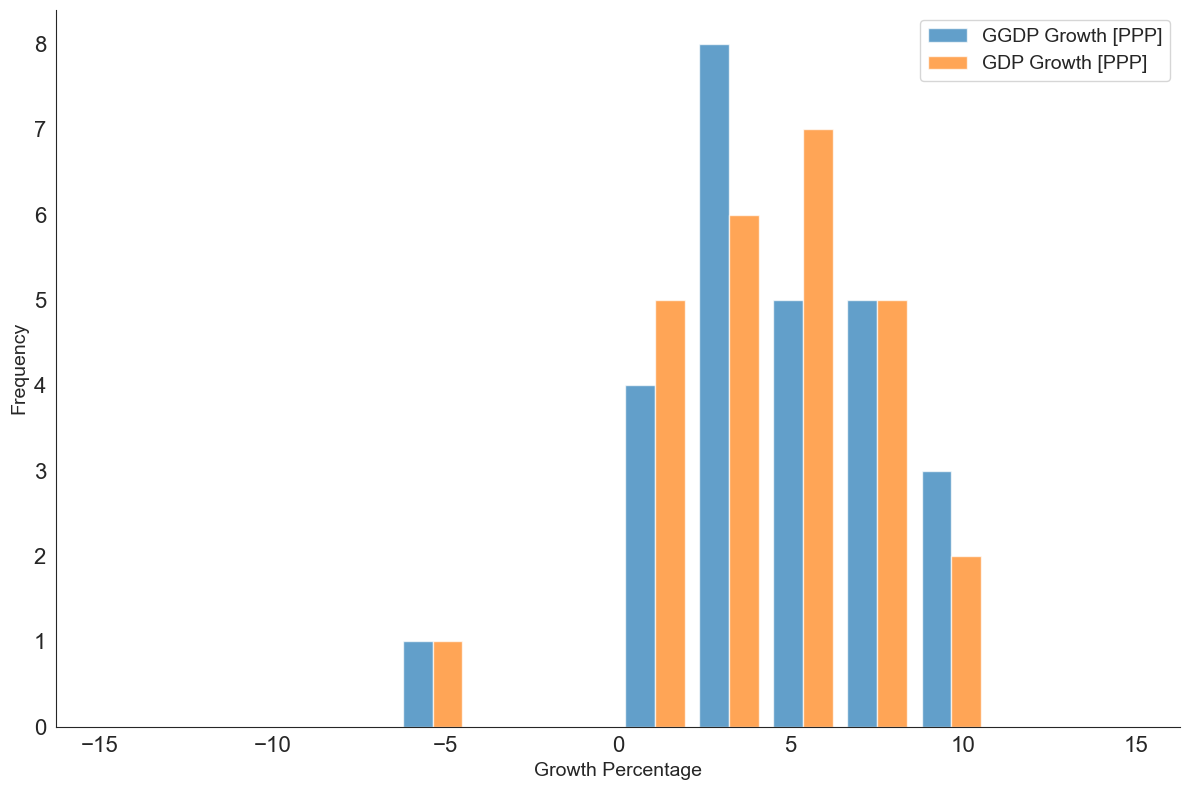

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style('white')

# Data preparation
ggdp_growth_percent = (finland_ggdp['ggdp_ppp_growth'].dropna(axis=0)) * 100
gdp_growth_percent = (finland_ggdp['gdp_ppp_growth'].dropna(axis=0)) * 100

# Bins for the histogram
bins = np.linspace(-15, 15, 15)

# Plotting the histogram
plt.figure(figsize=(12, 8))
plt.hist([ggdp_growth_percent, gdp_growth_percent], bins, label=['GGDP Growth [PPP]', 'GDP Growth [PPP]'], color=['#1f77b4', '#ff7f0e'], alpha=0.7)
plt.xlabel('Growth Percentage', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
#plt.title('Distribution of GGDP Growth [PPP] vs GDP Growth [PPP]', fontsize=16, fontweight='bold')

#framealpha=0.9, shadow=True, borderpad=1
#plt.legend(loc='upper right', fontsize=12, frameon=True,framealpha=0.9)
plt.legend(fontsize=14)
plt.grid(False)
plt.tick_params(axis='both', which='major', labelsize=12)

# Removing the right and top borders
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)

# Saving the plot
plt.tight_layout()
plt.savefig('./plots/ggdp_vs_gdp_ppp_distribution.png')
plt.show()


### Distributions analysis
The GGDP mean is lower from the GDP mean by 8bp accompanied by a  
2. 

The data samples are quite limited because of different factors, so I'm thinking of ways of expanding the dataset. Every sample I can get is helpful now.
- CO2 emission cost - I can perhaps try to use the CO2 damage as GNI instead of pricing the damage myself. There is much more available data there as carbon tax only started being implemented in the early 90s.
- WTE - The limitation here is electricity price which goes only back to 1995. My main limitation is electricity price.
I need to expand electricity prices somehow.
I think it's worth checking the difference between the CO2 emission cost that I priced compared to that of the CO2 damage as GNI to see the difference.

,ggdp_real_growth,ggdp_real_growth_par_damage,gdp_real_growth
count,26.000000,26.000000,26.000000
mean,0.019612,0.019625,0.020463
std,0.030255,0.030261,0.030255
min,-0.082114,-0.082120,-0.080744
25%,0.006772,0.006767,0.008729
50%,0.024775,0.024795,0.026949
75%,0.037544,0.037564,0.039109
max,0.060850,0.060875,0.063338
variance,0.000915,0.000916,0.000915
skewness,-1.499893,-1.499792,-1.514299


KS Test result: KS Value:0.038461538461538464, p-value: 0.9999999999999998


(array([[0., 0., 0., 0., 1., 0., 0., 0., 2., 4., 5., 8., 3., 3., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 3., 3., 4., 8., 5., 2., 0., 0.,
         0., 0., 0.]]),
 array([-15.        , -13.42105263, -11.84210526, -10.26315789,
         -8.68421053,  -7.10526316,  -5.52631579,  -3.94736842,
         -2.36842105,  -0.78947368,   0.78947368,   2.36842105,
          3.94736842,   5.52631579,   7.10526316,   8.68421053,
         10.26315789,  11.84210526,  13.42105263,  15.        ]),
 <a list of 2 BarContainer objects>)

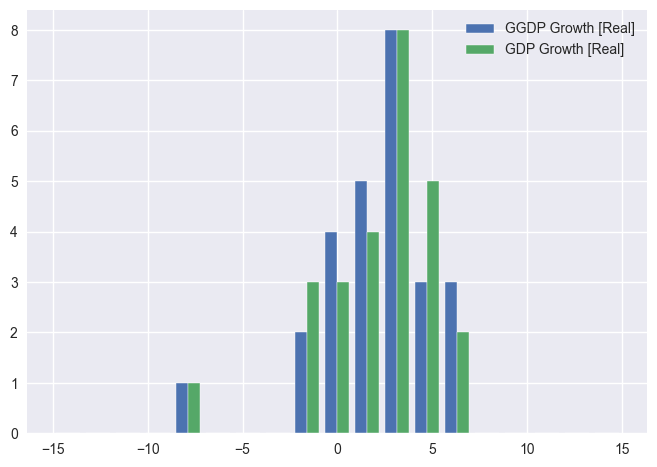

In [19]:
#GGDP vs GDP growth in real terms

from ggdp_calculation_utils import get_summary_statistics

#only keep data where both gdp and ggdp exist
finland_ggdp = finland_ggdp.dropna(subset=['ggdp_real_growth'], how='any', axis=0)

merged_summary_stats = get_summary_statistics(finland_ggdp, columns=['ggdp_real_growth', 'ggdp_real_growth_par_damage', 'gdp_real_growth'])

merged_summary_stats

ks_result = stats.ks_2samp(finland_ggdp['ggdp_real_growth'].dropna(), finland_ggdp['ggdp_real_growth_par_damage'].dropna())
print(f"KS Test result: KS Value:{ks_result.statistic}, p-value: {ks_result.pvalue}")

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

ggdp_growth_percent = (finland_ggdp['ggdp_real_growth'].dropna(axis=0)) * 100
gdp_growth_percent = (finland_ggdp['gdp_real_growth'].dropna(axis=0)) * 100


bins = np.linspace(-15, 15, 20)

plt.hist([ggdp_growth_percent, gdp_growth_percent], bins, label=['GGDP Growth [Real]', 'GDP Growth [Real]'])
plt.legend(loc='upper right')
plt.show()

 From WDI - Work Bank
 #### natural resources depletion
     Natural resource depletion is the sum of net forest depletion, energy depletion, and mineral depletion. Net forest depletion is unit resource rents times the excess of roundwood harvest over natural growth.
 #### Carbon Dioxide Damage
 	Cost of damage due to carbon dioxide emissions from fossil fuel use and the manufacture of cement, estimated to be US$40 per ton of CO2 (the unit damage in 2017 US dollars for CO2 emitted in 2020) times the number of tons of CO2 emitted.
 	my own opinion - it is calculated using a constant which can't really be constant over time because the cost of an emission of 1 kt of co2 in the 70s can't be the same as the cost it now because of the different environmental conditions that exist now, it is very unlikely to actually be a constant cost.
 #### Particulate Emission Damage
    Particulate emissions damage is the damage due to exposure of a country's population to ambient concentrations of particulates measuring less than 2.5 microns in diameter (PM2.5), ambient ozone pollution, and indoor concentrations of PM2.5 in households cooking with solid fuels.
    This perhaps can be included in the ggdp and maybe add a term for green innovation as well.

# GGDP - Calculating using imputed Electricity Prices
Add a bit of information accordingly

In [20]:
from data_reconstruction_functions import format_and_calculate_electricity_df

#loading non industrial imputed data
elec_hh_pre_2007_imputed = pd.read_csv('./ggdp_data/imputed_data/fi_hh_pre_2007_recovered.csv', header=0)
elec_hh_imputed = format_and_calculate_electricity_df(pre_2007_imputed_df=elec_hh_pre_2007_imputed,
                                    post_2007_df=elec_hh_post_2007_processed)

### loading industrial imputed data
elec_nh_pre_2007_imputed = pd.read_csv('./ggdp_data/imputed_data/fi_nh_pre_2007_recovered.csv', header=0)
elec_nh_imputed = format_and_calculate_electricity_df(pre_2007_imputed_df=elec_nh_pre_2007_imputed,
                                    post_2007_df=elec_nh_post_2007_processed)

C:\Users\yarde\PycharmProjects\ggdp_research\data_reconstruction_functions.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  elec_imputed = elec_imputed.replace(tax_tier_map)
C:\Users\yarde\PycharmProjects\ggdp_research\data_reconstruction_functions.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  elec_imputed = elec_imputed.replace(tax_tier_map)


In [21]:
finland_ggdp_imputed = pd.DataFrame()
#calculating GGDP with current data
#Calculating GGDP using base formula

#emission cost
#carbon tax is us$/ton of CO2
#perhaps need to convert this to ppp
finland_ggdp_imputed['co2_emission_cost_dollar'] = finland_data['finland_co2_kt'] * 1000 * finland_data['finland_carbon_tax']

#waste cost
#need to add electricity price
wte_conversion_constant = 400  # kWh/ton of waste
total_wte: pd.Series = finland_data['net_waste'] * wte_conversion_constant
years_index = list(total_wte.index)
years_series = pd.Series({year: int(year) for year in years_index}, index=years_index)
years_series.name = 'year'
wte_df = pd.concat([total_wte, years_series], axis=1)

#This is in EURO
#Need to convert EUR (lcu) to current dollars
finland_ggdp_imputed['waste_cost_eur'] = wte_df.apply(lambda x: calculate_energy_cost(wte=x['net_waste'],
                                                                                        year=x['year'], currency='EUR',
                                                                                        elec_consumption=elec_consump_processed,
                                                                                        hh_elec=elec_hh_imputed,
                                                                                        nh_elec=elec_nh_imputed)
                                                        , axis=1)

finland_ggdp_imputed = finland_ggdp_imputed.join(
    finland_data[['finland_dollar_to_lcu', 'finland_ppp_to_dollar', 'finland_as_particulate_emission_damage', 'finland_gdp_ppp']])
finland_ggdp_imputed['waste_cost_dollar'] = finland_ggdp_imputed['waste_cost_eur'] * finland_ggdp_imputed['finland_dollar_to_lcu']

#natural resource depltion cost in current dollar
finland_ggdp_imputed['natural_nrd_cost_dollar'] = finland_data['finland_as_nrd_cost']

#in current dollar
finland_ggdp_imputed['ggdp_current_dollar'] = finland_data['finland_gdp_dollar'] - finland_ggdp_imputed['co2_emission_cost_dollar'] - \
                              finland_ggdp_imputed[
                                  'waste_cost_dollar'] - finland_ggdp_imputed['natural_nrd_cost_dollar']
#in 2015 constant dollar. real terms
finland_ggdp_imputed['ggdp_constant_dollar'] = finland_ggdp_imputed['ggdp_current_dollar']/finland_data['gdp_2015_dollar_deflator']

#in ppp dollar
finland_ggdp_imputed['ggdp_dollar_ppp'] = finland_ggdp_imputed['ggdp_current_dollar'] * finland_ggdp_imputed['finland_ppp_to_dollar']

#deducting particulate damage to see if it affects the ggdp at all
finland_ggdp_imputed['ggdp_dollar_adjusted_particulate_damage'] = finland_ggdp_imputed['ggdp_current_dollar'] - finland_ggdp_imputed[
    'finland_as_particulate_emission_damage']

finland_ggdp_imputed['ggdp_constant_dollar_adjusted_particulate_damage'] = finland_ggdp_imputed['ggdp_dollar_adjusted_particulate_damage']/finland_data['gdp_2015_dollar_deflator']
finland_ggdp_imputed['ggdp_ppp_adjusted_particulate_damage'] = finland_ggdp_imputed['ggdp_dollar_adjusted_particulate_damage'] * \
                                                       finland_ggdp_imputed['finland_ppp_to_dollar']

#I'm interested in gdp growth so the currency doesn't matter as long as it represents ppp and not only currency. PPP is local currency/dollar so I will calculate ggdp in lcu (local currency units) controlled for ppp and then when I calculate growth it becomes unitless but is adjusted for real terms.

#adding ppp_lcu_to_dollar_to_data_frame
#finland_ggdp = finland_ggdp.join(finland_data['finland_ppp_lcu_to_dollar'])
#finland_ggdp['ggdp_lcu'] = finland_ggdp['ggdp_dollar'] * finland_ggdp['finland_ppp_lcu_to_dollar']
finland_ggdp_imputed['ggdp_ppp_growth'] = finland_ggdp_imputed['ggdp_dollar_ppp'] / finland_ggdp_imputed['ggdp_dollar_ppp'].shift(1) - 1
finland_ggdp_imputed['gdp_ppp_growth'] = finland_ggdp_imputed['finland_gdp_ppp'] / finland_ggdp_imputed['finland_gdp_ppp'].shift(1) - 1


#in real terms (not using ppp). using the ggdp we got from current dollars using the GDP deflator
finland_ggdp_imputed['ggdp_real_growth'] = finland_ggdp_imputed['ggdp_constant_dollar'] / finland_ggdp_imputed['ggdp_constant_dollar'].shift(1) - 1
finland_ggdp_imputed['gdp_real_growth'] = finland_data['finland_gdp_constant_2015_dollar'] / finland_data['finland_gdp_constant_2015_dollar'].shift(1) - 1

#in ppp as well
finland_ggdp_imputed['ggdp_ppp_growth_par_damage'] = finland_ggdp_imputed['ggdp_ppp_adjusted_particulate_damage'] / \
                                                      finland_ggdp_imputed['ggdp_ppp_adjusted_particulate_damage'].shift(1) - 1
#in real terms
finland_ggdp_imputed['ggdp_real_growth_par_damage'] = finland_ggdp_imputed['ggdp_constant_dollar_adjusted_particulate_damage'] / \
                                                      finland_ggdp_imputed['ggdp_constant_dollar_adjusted_particulate_damage'].shift(1) - 1

finland_ggdp_imputed.to_pickle('./ggdp_processed_data/finland_ggdp_imputed.pkl')

In [22]:
# from numpy import nan
# 
# from consumption_functions import calculate_energy_cost
# 
# finland_ggdp_imputed = pd.DataFrame()
# #calculating GGDP with current data
# #Calculating GGDP using base formula
# 
# #emission cost
# #carbon tax is us$/ton of CO2
# #perhaps need to convert this to ppp
# finland_ggdp_imputed['co2_emission_cost_dollar'] = finland_data['finland_co2_kt'] * 1000 * finland_data['finland_carbon_tax']
# 
# #waste cost
# #we used the existing wte dataframe that has data going back to 1990
# #This is in EURO
# finland_ggdp_imputed['waste_cost_eur'] = wte_df.apply(lambda x: calculate_energy_cost(wte=x['net_waste'],
#                                                                                         year=x['year'], currency='EUR',
#                                                                                         elec_consumption=elec_consump_processed,
#                                                                                         hh_elec=elec_hh_imputed,
#                                                                                         nh_elec=elec_nh_imputed)
#                                                         , axis=1)
# 
# finland_ggdp_imputed = finland_ggdp_imputed.join(
#     finland_data[['finland_dollar_to_lcu', 'finland_ppp_to_dollar', 'finland_as_particulate_emission_damage', 'finland_gdp_ppp']])
# finland_ggdp_imputed['waste_cost_dollar'] = finland_ggdp_imputed['waste_cost_eur'] * finland_ggdp_imputed[
#     'finland_dollar_to_lcu']
# 
# #natural resource depltion cost in current dollar
# finland_ggdp_imputed['natural_nrd_cost_dollar'] = finland_data['finland_as_nrd_cost']
# 
# #in current dollar
# finland_ggdp_imputed['ggdp_dollar'] = finland_data['finland_gdp_dollar'] - finland_ggdp_imputed[
#     'co2_emission_cost_dollar'] - \
#                                         finland_ggdp_imputed['waste_cost_dollar'] - finland_ggdp_imputed[
#                                             'natural_nrd_cost_dollar']
# 
# finland_ggdp_imputed['ggdp_ppp'] = finland_ggdp_imputed['ggdp_dollar'] * finland_ggdp_imputed[
#     'finland_ppp_to_dollar']
# 
# #deducting particulate damage to see if it affects the ggdp at all
# finland_ggdp_imputed['ggdp_dollar_adjusted_particulate_damage'] = finland_ggdp_imputed['ggdp_dollar'] - \
#                                                                     finland_ggdp_imputed[
#                                                                         'finland_as_particulate_emission_damage']
# finland_ggdp_imputed['ggdp_ppp_adjusted_particulate_damage'] = finland_ggdp_imputed[
#                                                                      'ggdp_dollar_adjusted_particulate_damage'] * \
#                                                                  finland_ggdp_imputed['finland_ppp_to_dollar']
# 
# #I'm interested in gdp growth so the currency doesn't matter as long as it represents ppp and not only currency. PPP is local currency/dollar so I will calculate ggdp in lcu (local currency units) controlled for ppp and then when I calculate growth it becomes unitless but is adjusted for real terms.
# 
# #adding ppp_lcu_to_dollar_to_data_frame
# #finland_ggdp = finland_ggdp.join(finland_data['finland_ppp_lcu_to_dollar'])
# #finland_ggdp['ggdp_lcu'] = finland_ggdp['ggdp_dollar'] * finland_ggdp['finland_ppp_lcu_to_dollar']
# finland_ggdp_imputed['ggdp_growth'] = finland_ggdp_imputed['ggdp_ppp'] / finland_ggdp_imputed['ggdp_ppp'].shift(
#     1) - 1
# finland_ggdp_imputed['gdp_growth'] = finland_ggdp_imputed['finland_gdp_ppp'] / finland_ggdp_imputed['finland_gdp_ppp'].shift(
#     1) - 1
# finland_ggdp_imputed['ggdp_with_particulate_damage_growth'] = finland_ggdp_imputed[
#                                                                     'ggdp_ppp_adjusted_particulate_damage'] / \
#                                                                 finland_ggdp_imputed[
#                                                                 'ggdp_ppp_adjusted_particulate_damage'].shift(1) - 1
# 
# #pickling ggdp data
# finland_ggdp.to_pickle('./ggdp_processed_data/finland_ggdp_imputed.pkl')


In [23]:
# finland_ggdp_imputed = finland_ggdp_imputed.dropna(subset=['ggdp_growth'], how='any', axis=0)
# 
# imp_merged_summary_stats = get_summary_statistics(finland_ggdp_imputed, columns=['ggdp_growth', 'ggdp_with_particulate_damage_growth', 'gdp_growth'])
# 
# imp_merged_summary_stats
# 
# ks_result = stats.ks_2samp(finland_ggdp_imputed['ggdp_growth'].dropna(), finland_ggdp_imputed['ggdp_with_particulate_damage_growth'].dropna())
# print(f"KS Test result: KS Value:{ks_result.statistic}, p-value: {ks_result.pvalue}")

In [29]:
from ggdp_calculation_utils import get_summary_statistics

#only keep data where both gdp and ggdp exist
finland_ggdp_imputed = finland_ggdp_imputed.dropna(subset=['ggdp_ppp_growth'], how='any', axis=0)

merged_summary_stats = get_summary_statistics(finland_ggdp_imputed, columns=['ggdp_ppp_growth', 'ggdp_ppp_growth_par_damage', 'gdp_ppp_growth'])

print(merged_summary_stats)

ks_result = stats.ks_2samp(finland_ggdp_imputed['ggdp_ppp_growth'].dropna(), finland_ggdp_imputed['ggdp_ppp_growth_par_damage'].dropna())
print(f"KS Test result: KS Value:{ks_result.statistic}, p-value: {ks_result.pvalue}")

          ggdp_ppp_growth  ggdp_ppp_growth_par_damage  gdp_ppp_growth
count           30.000000                   30.000000       30.000000
mean             0.043528                    0.043548        0.044565
std              0.033073                    0.033072        0.033490
min             -0.049245                   -0.049251       -0.048162
25%              0.023256                    0.023279        0.021408
50%              0.044432                    0.044451        0.048278
75%              0.062681                    0.062677        0.064037
max              0.104071                    0.104071        0.103132
variance         0.001094                    0.001094        0.001122
skewness        -0.574571                   -0.575106       -0.589236
kurtosis         0.741305                    0.743315        0.537269
KS Test result: KS Value:0.03333333333333333, p-value: 1.0


C:\Users\yarde\anaconda3\envs\ggdp-research\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


Again we can see that the KS value is really small and that the p-value is really large so we can't reject the null that both distributions are the same (or data from sample 1 is drawn from ecdf of sample 2).

In [25]:
from ggdp_calculation_utils import get_summary_statistics

#only keep data where both gdp and ggdp exist
finland_ggdp_imputed = finland_ggdp_imputed.dropna(subset=['ggdp_real_growth'], how='any', axis=0)

merged_summary_stats = get_summary_statistics(finland_ggdp_imputed, columns=['ggdp_real_growth', 'ggdp_real_growth_par_damage', 'gdp_real_growth'])

merged_summary_stats

ks_result = stats.ks_2samp(finland_ggdp_imputed['ggdp_real_growth'].dropna(), finland_ggdp_imputed['ggdp_real_growth_par_damage'].dropna())
print(f"KS Test result: KS Value:{ks_result.statistic}, p-value: {ks_result.pvalue}")

,ggdp_real_growth,ggdp_real_growth_par_damage,gdp_real_growth
count,30.000000,30.000000,30.000000
mean,0.018167,0.018186,0.019143
std,0.030275,0.030279,0.030657
min,-0.081790,-0.081797,-0.080744
25%,0.004369,0.004385,0.006037
50%,0.023297,0.023301,0.026949
75%,0.038425,0.038490,0.039848
max,0.060276,0.060301,0.063338
variance,0.000917,0.000917,0.000940
skewness,-1.285436,-1.285443,-1.301035


KS Test result: KS Value:0.03333333333333333, p-value: 1.0


C:\Users\yarde\anaconda3\envs\ggdp-research\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


(array([[0., 0., 0., 0., 1., 0., 1., 5., 8., 8., 5., 2., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 6., 6., 9., 5., 2., 0., 0.]]),
 array([-15.        , -12.85714286, -10.71428571,  -8.57142857,
         -6.42857143,  -4.28571429,  -2.14285714,   0.        ,
          2.14285714,   4.28571429,   6.42857143,   8.57142857,
         10.71428571,  12.85714286,  15.        ]),
 <a list of 2 BarContainer objects>)

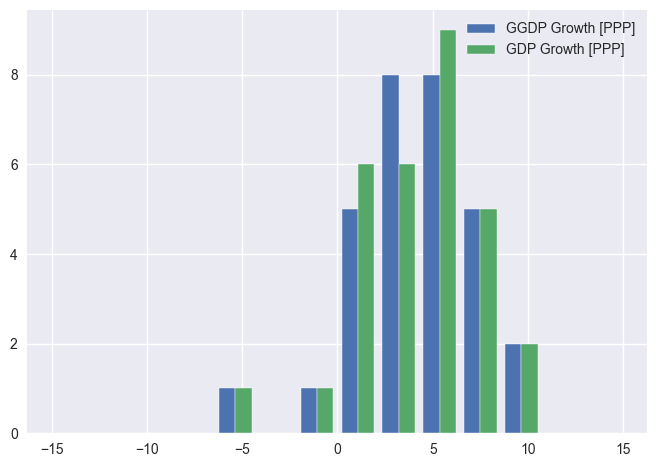

In [26]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

ggdp_growth_percent = (finland_ggdp_imputed['ggdp_ppp_growth'].dropna(axis=0)) * 100
gdp_growth_percent = (finland_ggdp_imputed['gdp_ppp_growth'].dropna(axis=0)) * 100


bins = np.linspace(-15, 15, 15)

plt.hist([ggdp_growth_percent, gdp_growth_percent], bins, label=['GGDP Growth [PPP]', 'GDP Growth [PPP]'])
plt.legend(loc='upper right')
plt.show()

(array([[ 0.,  0.,  0.,  1.,  0.,  1.,  5.,  7., 12.,  4.,  0.,  0.,  0.,
          0.],
        [ 0.,  0.,  0.,  1.,  0.,  2.,  4.,  6., 12.,  5.,  0.,  0.,  0.,
          0.]]),
 array([-15.        , -12.85714286, -10.71428571,  -8.57142857,
         -6.42857143,  -4.28571429,  -2.14285714,   0.        ,
          2.14285714,   4.28571429,   6.42857143,   8.57142857,
         10.71428571,  12.85714286,  15.        ]),
 <a list of 2 BarContainer objects>)

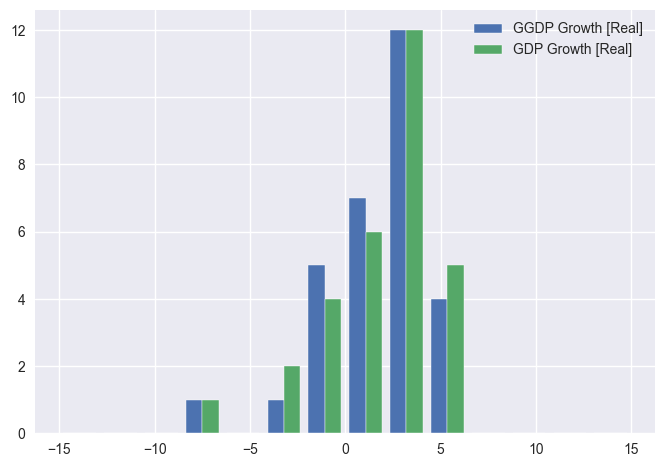

In [27]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

ggdp_growth_percent = (finland_ggdp_imputed['ggdp_real_growth'].dropna(axis=0)) * 100
gdp_growth_percent = (finland_ggdp_imputed['gdp_real_growth'].dropna(axis=0)) * 100


bins = np.linspace(-15, 15, 15)

plt.hist([ggdp_growth_percent, gdp_growth_percent], bins, label=['GGDP Growth [Real]', 'GDP Growth [Real]'])
plt.legend(loc='upper right')
plt.show()

## PPP, LCU constant or Current?

When looking at monetary units we have 3 main units to consider: LCU (local current unit), current dollar, constant dollar.
LCU - measures the economy in local currency, the problem is we can really compare across different economies using this
Current Dollar - nominal value, doesn't account inflation.
Constant Dollar - real value, adjusted for inflation

Which one should we use?
 
GDP is measured using three different currencies. which should I use? I have to write here something about this

In [ ]:

#comment for pushing